# Libraries

In [2]:
import sys
sys.path.append("./")
from utils import train_test_split

from tqdm.auto import tqdm 
tqdm.pandas()
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

# Preprocessing

In [3]:
DATA = "data/"

data = pd.read_csv(DATA + "fact_train_test.csv", sep=";")
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,"71,0",1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,"210,0",3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,"67,0",1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,"67,0",1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,"66,0",1
...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,"69,0",1
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,"70,0",1
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,"70,0",1
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,"207,0",3


In [4]:
data["period"] = pd.to_datetime(data["period"])
data["real_weight"] = data["real_weight"].apply(lambda x: float(x.replace(",", ".")))
data = data[data["real_weight"] >= 0]
data = data.sort_values(by="period")
data.shape

(3559215, 11)

In [5]:
data = data[data["period"] > datetime.datetime(2017, 1, 1)]
data.shape

(3514465, 11)

# FE 

In [6]:
datetime_columns = ["period"]

In [7]:
def add_time_series_features(df, data_cols=['period']):
    features = []
    for col in datetime_columns:
        features.extend([col + "_year", col + "_day", col + "_weekday", col + "_month"])
        df[col] = df[col].fillna(df[col].mode())
        df[col] = pd.to_datetime(df[col], format="%Y-%m-%d",errors='coerce')
        df[col + "_year"] = df[col].dt.year
        df[col + "_day"] = df[col].dt.day
        df[col + "_weekday"] = df[col].dt.weekday
        df[col + "_month"] = df[col].dt.month
        df[col + "_seconds"] = df[col].apply(lambda x: (x - datetime.datetime(1970, 1, 1)).total_seconds())
    return df, features


def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    client_mapping_file = "./data/client_mapping.csv"
    freight_mapping_file = "./data/freight_mapping.csv"
    station_mapping_file = "./data/station_mapping.csv"
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df


data, cat_datetime_fe = add_time_series_features(data)
data = add_master_data_mappings(data)
data["holding_name"] = data["holding_name"].fillna(-1).astype("int")

In [8]:
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,...,period_day,period_weekday,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2017-02-01,1,5,1,-1,1682,12676,12195,3464,128.0,...,1,2,2,1.485907e+09,-1,39,36,4,54,4
1,2017-02-01,1,5,1,-1,1682,12676,12195,5244,68.0,...,1,2,2,1.485907e+09,-1,39,36,4,54,4
2,2017-02-01,1,5,1,-1,1682,12676,35462,5244,39.0,...,1,2,2,1.485907e+09,-1,39,36,4,104,10
3,2017-02-01,1,5,1,-1,1682,38063,33596,9075,62.0,...,1,2,2,1.485907e+09,-1,39,18,9,141,29
4,2017-02-01,1,5,1,-1,1682,12676,28542,3464,64.0,...,1,2,2,1.485907e+09,-1,39,36,4,134,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514460,2023-03-01,0,2,2,2129,1697,35809,30792,25817,194.0,...,1,2,3,1.677629e+09,519,39,79,10,2,12
3514461,2023-03-01,0,2,2,2129,1697,35809,31112,25817,65.0,...,1,2,3,1.677629e+09,519,39,79,10,4,12
3514462,2023-03-01,0,2,2,2129,1708,35667,38470,25817,659.0,...,1,2,3,1.677629e+09,519,39,79,10,76,6
3514463,2023-03-01,0,2,2,2129,2120,35809,36430,25817,66.0,...,1,2,3,1.677629e+09,519,14,79,10,8,16


In [9]:
binary_features = pd.read_csv(DATA + "binary_map.csv", index_col=0)
binary_features

,freight_id,client_sap_id,sender_station_id,recipient_station_id,sender_organisation_id,rps,filial,podrod,period_0,period_1,...,period_75,period_76,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84
0,0,-1,1576,37851,0,1,2,5,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,-1,1576,38902,0,1,2,5,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,-1,2977,38567,7152,0,2,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,-1,3801,26930,7152,0,2,1,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,-1,3845,28207,8535,0,2,1,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025493,5086,-1,32475,32012,7667,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1025494,5086,-1,32475,32013,7667,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1025495,5086,-1,38832,34766,25860,1,1,5,False,False,...,False,False,False,False,False,False,False,False,True,False
1025496,5086,102,1916,31527,11906,0,1,2,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
data = data.merge(binary_features, how='left', on=['freight_id',
                                                   'client_sap_id',
                                                   'sender_station_id',
                                                   'recipient_station_id',
                                                   'sender_organisation_id',
                                                   'rps',
                                                   'filial',
                                                   'podrod'])

In [11]:
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,...,period_75,period_76,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84
0,2017-02-01,1,5,1,-1,1682,12676,12195,3464,128.0,...,False,False,False,False,False,False,False,False,False,False
1,2017-02-01,1,5,1,-1,1682,12676,12195,5244,68.0,...,False,False,False,False,False,False,False,False,False,False
2,2017-02-01,1,5,1,-1,1682,12676,35462,5244,39.0,...,False,False,False,False,False,False,False,False,False,False
3,2017-02-01,1,5,1,-1,1682,38063,33596,9075,62.0,...,False,False,False,False,False,False,False,False,False,False
4,2017-02-01,1,5,1,-1,1682,12676,28542,3464,64.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514460,2023-03-01,0,2,2,2129,1697,35809,30792,25817,194.0,...,False,False,False,False,False,True,True,True,True,True
3514461,2023-03-01,0,2,2,2129,1697,35809,31112,25817,65.0,...,False,False,False,False,False,False,False,False,False,True
3514462,2023-03-01,0,2,2,2129,1708,35667,38470,25817,659.0,...,False,False,False,False,False,False,False,False,False,True
3514463,2023-03-01,0,2,2,2129,2120,35809,36430,25817,66.0,...,False,False,False,False,False,False,False,False,False,True


In [12]:
cols = [f'period_{i}' for i in range(72, 85)]

In [13]:
def get_num_period(row):
    return row[cols].sum()

In [14]:
data['freq'] = data.progress_apply(get_num_period, axis=1)

  0%|          | 0/3514465 [00:00<?, ?it/s]

In [15]:
threshold = 3

In [16]:
data.freq.value_counts()

freq
0     2862135
1      124123
2       86174
3       66973
4       54932
5       49606
6       42287
13      41648
7       37692
8       35996
9       30698
10      29526
12      26861
11      25814
Name: count, dtype: int64

In [17]:
high_data, low_data = data[data['freq']>=threshold].copy(), data[data['freq']<threshold].copy()

In [18]:
high_data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,...,period_76,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84,freq
47526,2017-02-01,1,5,0,1243,1698,32975,34665,7344,67.0,...,False,False,False,True,True,True,True,True,True,6
59570,2017-03-01,1,5,1,-1,1714,27001,34665,10212,185.0,...,False,False,False,True,False,True,True,True,True,5
59612,2017-03-01,1,5,1,-1,1530,27202,2018,10437,207.0,...,False,False,False,True,True,True,True,True,True,6
60119,2017-03-01,1,5,1,-1,1063,36025,32942,7322,685.0,...,False,False,False,True,True,False,False,True,True,4
70076,2017-03-01,1,5,1,-1,1166,33823,34665,7547,272.0,...,False,False,False,True,True,True,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514454,2023-03-01,0,2,2,2129,1127,27910,35667,27697,66.0,...,False,False,False,False,True,True,True,True,True,5
3514457,2023-03-01,0,2,2,2129,1776,37412,35809,26297,66.0,...,False,False,False,False,False,True,False,True,True,3
3514458,2023-03-01,0,2,2,2129,1776,9390,32810,30685,65.0,...,False,False,False,False,True,True,True,True,True,5
3514460,2023-03-01,0,2,2,2129,1697,35809,30792,25817,194.0,...,False,False,False,False,True,True,True,True,True,5


In [19]:
high_test_dates = set(high_data["period"].unique()[-5:])
high_data["is_test"] = high_data["period"].progress_apply(lambda x: x in high_test_dates)
high_data["is_test"].sum(), high_data["is_test"].shape[0] - high_data["is_test"].sum()

  0%|          | 0/442033 [00:00<?, ?it/s]

(144606, 297427)

In [20]:
high_train, high_test = high_data[high_data["is_test"] == False], high_data[high_data["is_test"] == True]
high_train, high_test = high_train.drop(columns=["is_test"]), high_test.drop(columns=["is_test"])
high_train.shape, high_test.shape

((297427, 108), (144606, 108))

In [21]:
low_test_dates = set(low_data["period"].unique()[-5:])
low_data["is_test"] = low_data["period"].progress_apply(lambda x: x in low_test_dates)
low_data["is_test"].sum(), low_data["is_test"].shape[0] - low_data["is_test"].sum()

  0%|          | 0/3072432 [00:00<?, ?it/s]

(74222, 2998210)

In [22]:
low_train, low_test = low_data[low_data["is_test"] == False], low_data[low_data["is_test"] == True]
low_train, low_test = low_train.drop(columns=["is_test"]), low_test.drop(columns=["is_test"])
low_train.shape, low_test.shape

((2998210, 108), (74222, 108))

# Model

In [24]:
high_model = CatBoostRegressor(
    n_estimators=5000,
    random_state=42,
    task_type="GPU",
    loss_function="RMSE"
)

low_model = CatBoostRegressor(
    max_depth=6,
    random_state=42,
    task_type="GPU",
    loss_function="RMSE"
)

## Low

In [25]:
low_train = low_train.drop(columns=["real_weight"])
low_test = low_test.drop(columns=["real_weight"])

In [26]:
low_X_train, low_X_test, low_y_train, low_y_test = low_train.drop(columns=["real_wagon_count"]), low_test.drop(columns=["real_wagon_count"]), low_train["real_wagon_count"], low_test["real_wagon_count"]
low_X_train.shape[0], low_X_test.shape[0], low_y_train.shape[0], low_y_test.shape[0]

(2998210, 74222, 2998210, 74222)

In [27]:
cat_datetime_fe

['period_year', 'period_day', 'period_weekday', 'period_month']

In [28]:
low_cat_features =["podrod", "filial", "sender_organisation_id"] + \
cat_datetime_fe + \
['recipient_department_name', 'recipient_railway_name', 'sender_department_name', 'sender_railway_name', "freight_group_name", "holding_name"]


In [29]:
low_model.fit(
    low_X_train.drop(columns=['freight_id', 
                              'sender_station_id',
                              'recipient_station_id', 
                              'client_sap_id']),
    low_y_train,
    eval_set=(low_X_test.drop(columns=['freight_id', 
                                       'sender_station_id',
                                       'recipient_station_id', 
                                       'client_sap_id']), low_y_test),
    cat_features=low_cat_features,
    use_best_model=True
)

Learning rate set to 0.147439
0:	learn: 122.5319199	test: 27.9372847	best: 27.9372847 (0)	total: 61.9ms	remaining: 1m 1s
1:	learn: 119.7158689	test: 27.2148034	best: 27.2148034 (1)	total: 123ms	remaining: 1m 1s
2:	learn: 117.1247155	test: 26.6463409	best: 26.6463409 (2)	total: 186ms	remaining: 1m 1s
3:	learn: 115.2700270	test: 26.2539341	best: 26.2539341 (3)	total: 247ms	remaining: 1m 1s
4:	learn: 113.6461680	test: 25.7951116	best: 25.7951116 (4)	total: 308ms	remaining: 1m 1s
5:	learn: 112.4864626	test: 25.7312426	best: 25.7312426 (5)	total: 368ms	remaining: 1m
6:	learn: 111.3677126	test: 25.5598614	best: 25.5598614 (6)	total: 426ms	remaining: 1m
7:	learn: 110.3140401	test: 25.3407326	best: 25.3407326 (7)	total: 487ms	remaining: 1m
8:	learn: 109.4209126	test: 25.2256727	best: 25.2256727 (8)	total: 551ms	remaining: 1m
9:	learn: 108.6612003	test: 25.1630120	best: 25.1630120 (9)	total: 600ms	remaining: 59.4s
10:	learn: 107.7331040	test: 25.0148532	best: 25.0148532 (10)	total: 649ms	remain

In [30]:
low_model.get_feature_importance(prettified=True).to_dict()

{'Feature Id': {0: 'freight_group_name',
  1: 'podrod',
  2: 'sender_organisation_id',
  3: 'recipient_department_name',
  4: 'period_10',
  5: 'recipient_railway_name',
  6: 'holding_name',
  7: 'sender_department_name',
  8: 'sender_railway_name',
  9: 'filial',
  10: 'period_28',
  11: 'period_38',
  12: 'period_51',
  13: 'period_65',
  14: 'period_34',
  15: 'period_49',
  16: 'period_68',
  17: 'period_59',
  18: 'period_14',
  19: 'period_63',
  20: 'period_41',
  21: 'period_26',
  22: 'period_27',
  23: 'period_17',
  24: 'period_33',
  25: 'period_15',
  26: 'period_13',
  27: 'period_22',
  28: 'period_16',
  29: 'period_35',
  30: 'period_69',
  31: 'period_40',
  32: 'period_64',
  33: 'period_46',
  34: 'period_11',
  35: 'period_61',
  36: 'period_55',
  37: 'period_52',
  38: 'period_21',
  39: 'period_45',
  40: 'period_year',
  41: 'period_37',
  42: 'period_57',
  43: 'period_58',
  44: 'period_20',
  45: 'period_50',
  46: 'period_seconds',
  47: 'period_0',
  48: '

In [31]:
import numpy as np
low_preds = low_model.predict(low_X_test.drop(columns=['freight_id', 
                              'sender_station_id',
                              'recipient_station_id', 
                              'client_sap_id']))
low_preds[low_preds < 0] = 0
low_preds

array([7.77254415, 8.43093373, 5.10953075, ..., 0.        , 0.        ,
       0.        ])

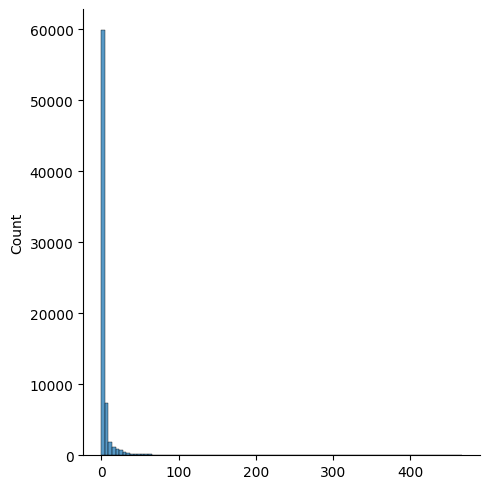

In [32]:
sns.displot(low_preds, bins=100)

## High

In [33]:
high_train = high_train.drop(columns=["real_weight"])
high_test = high_test.drop(columns=["real_weight"])

In [34]:
high_X_train, high_X_test, high_y_train, high_y_test = high_train.drop(columns=["real_wagon_count"]), high_test.drop(columns=["real_wagon_count"]), high_train["real_wagon_count"], high_test["real_wagon_count"]
high_X_train.shape[0], high_X_test.shape[0], high_y_train.shape[0], high_y_test.shape[0]

(297427, 144606, 297427, 144606)

In [35]:
cat_datetime_fe

['period_year', 'period_day', 'period_weekday', 'period_month']

In [36]:
high_cat_features =["podrod", "filial", "sender_organisation_id"] + \
cat_datetime_fe + \
['freight_id', 'sender_station_id','recipient_station_id', 'client_sap_id']


In [37]:
high_model.fit(
    high_X_train.drop(columns=['recipient_department_name', 
                               'recipient_railway_name', 
                               'sender_department_name', 
                               'sender_railway_name', 
                               "freight_group_name",
                               "holding_name"]),
    high_y_train,
    eval_set=(high_X_test.drop(columns=['recipient_department_name', 
                                        'recipient_railway_name', 
                                        'sender_department_name', 
                                        'sender_railway_name', 
                                        "freight_group_name",
                                        "holding_name"]), high_y_test),
    cat_features=high_cat_features,
    use_best_model=True
)

Learning rate set to 0.072616
0:	learn: 158.5246073	test: 164.7756211	best: 164.7756211 (0)	total: 12ms	remaining: 1m
1:	learn: 155.8312135	test: 162.5807060	best: 162.5807060 (1)	total: 25.5ms	remaining: 1m 3s
2:	learn: 153.5102646	test: 160.7057943	best: 160.7057943 (2)	total: 36.8ms	remaining: 1m 1s
3:	learn: 151.1920568	test: 159.7843172	best: 159.7843172 (3)	total: 48.6ms	remaining: 1m
4:	learn: 149.1713240	test: 158.1096636	best: 158.1096636 (4)	total: 59.8ms	remaining: 59.8s
5:	learn: 147.2368703	test: 157.3250075	best: 157.3250075 (5)	total: 71.8ms	remaining: 59.8s
6:	learn: 145.4371774	test: 156.3156055	best: 156.3156055 (6)	total: 83ms	remaining: 59.2s
7:	learn: 144.1511466	test: 155.4330273	best: 155.4330273 (7)	total: 94.3ms	remaining: 58.8s
8:	learn: 142.6838358	test: 154.9084060	best: 154.9084060 (8)	total: 105ms	remaining: 58.3s
9:	learn: 141.6108004	test: 154.4471562	best: 154.4471562 (9)	total: 117ms	remaining: 58.5s
10:	learn: 140.2300318	test: 153.6898849	best: 153.6

In [38]:
high_model.get_feature_importance(prettified=True).to_dict()

{'Feature Id': {0: 'freight_id',
  1: 'freq',
  2: 'recipient_station_id',
  3: 'sender_organisation_id',
  4: 'sender_station_id',
  5: 'client_sap_id',
  6: 'podrod',
  7: 'period_year',
  8: 'period_69',
  9: 'filial',
  10: 'period_44',
  11: 'period_67',
  12: 'period_month',
  13: 'period',
  14: 'period_46',
  15: 'period_weekday',
  16: 'period_70',
  17: 'period_seconds',
  18: 'period_59',
  19: 'period_65',
  20: 'period_71',
  21: 'period_68',
  22: 'period_52',
  23: 'period_51',
  24: 'period_45',
  25: 'period_75',
  26: 'period_81',
  27: 'period_61',
  28: 'period_74',
  29: 'period_76',
  30: 'period_73',
  31: 'period_60',
  32: 'period_62',
  33: 'period_53',
  34: 'period_63',
  35: 'period_77',
  36: 'period_84',
  37: 'period_48',
  38: 'period_50',
  39: 'period_55',
  40: 'period_40',
  41: 'period_36',
  42: 'period_49',
  43: 'period_78',
  44: 'period_58',
  45: 'period_64',
  46: 'period_82',
  47: 'period_83',
  48: 'period_35',
  49: 'period_80',
  50: 'p

In [39]:
import numpy as np
high_preds = high_model.predict(high_X_test.drop(columns=['recipient_department_name', 
                                                      'recipient_railway_name', 
                                                      'sender_department_name', 
                                                      'sender_railway_name', 
                                                      "freight_group_name",
                                                      "holding_name"]))
high_preds[high_preds < 0] = 0
high_preds

array([ 0.        , 11.6333587 ,  4.04969217, ...,  0.        ,
        0.        ,  0.98848498])

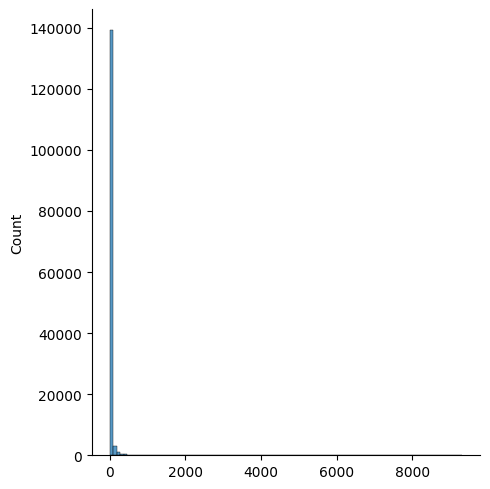

In [40]:
sns.displot(high_preds, bins=100)

# Evaluate

In [41]:
import numpy as np


def evaluate(fact: pd.DataFrame, forecast: pd.DataFrame, public: bool = True) -> float:
    # = Параметры для расчета метрики =
    accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
    fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"
    if public:
        metric_weight = np.array([0.0, 1.0, 0.0, 0.0, 0.0])
    else:
        metric_weight = np.array([0.1, 0.6, 0.1, 0.1, 0.1])

    # = Собственно расчет метрик =
    # 1. Добавляем сущности верхних уровней гранулярности по справочникам
    # fact = add_master_data_mappings(fact)
    # forecast = add_master_data_mappings(forecast)

    # 2. Расчет KPI
    compare_data = pd.merge(
        fact.groupby(accuracy_granularity, as_index=False)[fact_value].sum(),
        forecast.groupby(accuracy_granularity, as_index=False)[forecast_value].sum(),
        how="outer",
        on=accuracy_granularity,
    ).fillna(0)
    # Против самых хитрых - нецелочисленный прогноз вагоноотправок не принимаем
    compare_data[fact_value] = np.around(compare_data[fact_value]).astype(int)
    compare_data[forecast_value] = np.around(compare_data[forecast_value]).astype(int)

    # 3. Рассчитаем метрики для каждого месяца в выборке
    compare_data["ABS_ERR"] = abs(
        compare_data[forecast_value] - compare_data[fact_value]
    )
    compare_data["MAX"] = abs(compare_data[[forecast_value, fact_value]].max(axis=1))
    summary = compare_data.groupby("period")[
        [forecast_value, fact_value, "ABS_ERR", "MAX"]
    ].sum()
    summary["Forecast Accuracy"] = 1 - summary["ABS_ERR"] / summary["MAX"]

    # 4. Взвесим метрики отдельных месяцев для получения одной цифры score
    score = (
        summary["Forecast Accuracy"].sort_index(ascending=True) * metric_weight
    ).sum()

    return score


def calc_score_public(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=True)


def calc_score_private(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=False)

In [42]:
fact = pd.concat([low_X_test, high_X_test])
fact["real_wagon_count"] = pd.concat([low_y_test, high_y_test])
fact = fact[fact["real_wagon_count"] > 0]

In [43]:
import numpy as np

In [44]:
forecast = pd.concat([low_X_test, high_X_test])
forecast["forecast_wagon_count"] = np.concatenate([low_preds, high_preds])
forecast = forecast[forecast["forecast_wagon_count"] > 0]



In [45]:
forecast

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84,freq,forecast_wagon_count
3295638,2022-11-01,1,5,1,-1,1078,9118,28149,29814,2022,...,False,False,False,True,False,False,False,False,1,7.772544
3295640,2022-11-01,1,5,1,-1,1078,10863,9746,31858,2022,...,False,False,True,True,False,False,False,False,2,8.430934
3295646,2022-11-01,1,5,1,-1,1078,9118,2670,29814,2022,...,False,False,False,True,False,False,False,False,1,5.109531
3295652,2022-11-01,1,5,1,-1,1078,9118,10167,29814,2022,...,False,False,True,True,False,False,False,False,2,7.073623
3295674,2022-11-01,1,5,1,-1,1078,32714,12142,26200,2022,...,False,False,False,True,False,False,False,False,1,9.134198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514434,2023-03-01,0,2,2,87,2357,24410,25206,25964,2023,...,False,False,True,True,False,False,True,True,4,0.285047
3514439,2023-03-01,0,2,2,2129,1708,35667,36256,25817,2023,...,False,False,False,True,True,True,True,True,5,5.807773
3514440,2023-03-01,0,2,2,2129,1708,35667,36446,25817,2023,...,False,False,False,False,True,False,True,True,3,0.014500
3514444,2023-03-01,0,2,2,514,1460,33107,11150,27725,2023,...,True,True,True,True,False,True,True,True,11,14.143523


In [46]:
# Скорим
score_public = calc_score_public(fact, forecast)
score_private = calc_score_private(fact, forecast)
print(f"Public score: {score_public}")
print(f"Private score: {score_private}")

Public score: 0.6198824650426964
Private score: 0.5150577200976048


С отрицательными значениями: 
Public score: 0.6031490080789712
Private score: 0.41790083598674166

Предикты меньше 0 заменить 0
Public score: 0.6159311265690937
Private score: 0.562187435265229

Все записи, где 0 дропнуть
Public score: 0.6159311265690937
Private score: 0.562187435265229

Фичи с весом 1 вагона:
Public score: 0.6140041549902395
Private score: 0.557186562527978

# Final Model

In [62]:
X, y = data.drop(columns=["real_wagon_count", "is_test", "real_weight"]), data["real_wagon_count"]
X

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_75,period_76,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84
0,2017-02-01,1,5,1,-1,1682,12676,12195,3464,2017,...,False,False,False,False,False,False,False,False,False,False
1,2017-02-01,1,5,1,-1,1682,12676,12195,5244,2017,...,False,False,False,False,False,False,False,False,False,False
2,2017-02-01,1,5,1,-1,1682,12676,35462,5244,2017,...,False,False,False,False,False,False,False,False,False,False
3,2017-02-01,1,5,1,-1,1682,38063,33596,9075,2017,...,False,False,False,False,False,False,False,False,False,False
4,2017-02-01,1,5,1,-1,1682,12676,28542,3464,2017,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514460,2023-03-01,0,2,2,2129,1697,35809,30792,25817,2023,...,False,False,False,False,False,True,True,True,True,True
3514461,2023-03-01,0,2,2,2129,1697,35809,31112,25817,2023,...,False,False,False,False,False,False,False,False,False,True
3514462,2023-03-01,0,2,2,2129,1708,35667,38470,25817,2023,...,False,False,False,False,False,False,False,False,False,True
3514463,2023-03-01,0,2,2,2129,2120,35809,36430,25817,2023,...,False,False,False,False,False,False,False,False,False,True


In [63]:
params = model.get_all_params()
params["iterations"] = params["iterations"] + 100

In [64]:
new_params = {
    "iterations": params["iterations"],
    "depth":params["depth"],
    "learning_rate":params["learning_rate"],
    "random_seed":params["random_seed"],
    "task_type": params["task_type"],
}
new_params

{'iterations': 1100,
 'depth': 6,
 'learning_rate': 0.14895300567150116,
 'random_seed': 42,
 'task_type': 'GPU'}

In [65]:
final_model = CatBoostRegressor(
    **new_params
)

In [66]:
final_model.fit(
    X,
    y,
    cat_features=cat_features)

0:	learn: 126.2906806	total: 77.5ms	remaining: 1m 25s
1:	learn: 123.4256438	total: 158ms	remaining: 1m 26s
2:	learn: 121.1392285	total: 237ms	remaining: 1m 26s
3:	learn: 118.9862077	total: 314ms	remaining: 1m 26s
4:	learn: 117.2070751	total: 387ms	remaining: 1m 24s
5:	learn: 115.7149807	total: 474ms	remaining: 1m 26s
6:	learn: 114.3366773	total: 563ms	remaining: 1m 27s
7:	learn: 113.3237152	total: 638ms	remaining: 1m 27s
8:	learn: 112.4127050	total: 726ms	remaining: 1m 27s
9:	learn: 111.4698457	total: 807ms	remaining: 1m 27s
10:	learn: 110.7156931	total: 881ms	remaining: 1m 27s
11:	learn: 110.0769918	total: 956ms	remaining: 1m 26s
12:	learn: 109.0402902	total: 1.03s	remaining: 1m 26s
13:	learn: 108.5489157	total: 1.12s	remaining: 1m 27s
14:	learn: 108.0729832	total: 1.2s	remaining: 1m 26s
15:	learn: 107.5678134	total: 1.26s	remaining: 1m 25s
16:	learn: 107.1302728	total: 1.34s	remaining: 1m 25s
17:	learn: 106.4961145	total: 1.44s	remaining: 1m 26s
18:	learn: 105.7941604	total: 1.5s	rem

In [67]:
forecast_example = pd.read_csv(DATA + "forecast_example.csv", sep=";").drop(columns=["forecast_wagon_count"])
forecast_example

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,"73,0"
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,"146,0"
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,"876,0"
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,"473,0"
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,"63,0"
...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,"69,0"
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,"70,0"
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,"70,0"
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,"207,0"


In [68]:
forecast_example["period"] = pd.to_datetime(forecast_example["period"])

forecast_example.shape

(239605, 10)

In [69]:
forecast_example, cat_datetime_fe = add_time_series_features(forecast_example)
forecast_example = add_master_data_mappings(forecast_example)
forecast_example["holding_name"] = forecast_example["holding_name"].fillna(-1).astype("int")

In [70]:
X_train

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_75,period_76,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84
0,2017-02-01,1,5,1,-1,1682,12676,12195,3464,2017,...,False,False,False,False,False,False,False,False,False,False
1,2017-02-01,1,5,1,-1,1682,12676,12195,5244,2017,...,False,False,False,False,False,False,False,False,False,False
2,2017-02-01,1,5,1,-1,1682,12676,35462,5244,2017,...,False,False,False,False,False,False,False,False,False,False
3,2017-02-01,1,5,1,-1,1682,38063,33596,9075,2017,...,False,False,False,False,False,False,False,False,False,False
4,2017-02-01,1,5,1,-1,1682,12676,28542,3464,2017,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295632,2022-10-01,0,2,1,1476,1087,20148,35451,26870,2022,...,True,True,True,True,True,True,True,True,False,True
3295633,2022-10-01,0,2,1,837,1041,33901,24640,26544,2022,...,True,True,True,True,True,True,False,False,False,False
3295634,2022-10-01,0,2,1,837,1041,33901,34208,26544,2022,...,True,True,True,True,True,True,True,False,False,True
3295635,2022-10-01,0,2,1,866,349,37358,38966,29645,2022,...,False,False,False,False,True,False,False,False,False,False


In [71]:
X.columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'period_year',
       ...
       'period_75', 'period_76', 'period_77', 'period_78', 'period_79',
       'period_80', 'period_81', 'period_82', 'period_83', 'period_84'],
      dtype='object', length=105)

In [72]:
forecast_example.columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'forecast_weight', 'period_year', 'period_day', 'period_weekday',
       'period_month', 'period_seconds', 'holding_name', 'freight_group_name',
       'sender_department_name', 'sender_railway_name',
       'recipient_department_name', 'recipient_railway_name'],
      dtype='object')

In [73]:
forecast_example = forecast_example.merge(binary_features, how='left', on=['freight_id',
                                                   'client_sap_id',
                                                   'sender_station_id',
                                                   'recipient_station_id',
                                                   'sender_organisation_id',
                                                   'rps',
                                                   'filial',
                                                   'podrod'])

In [74]:
forecast_example = forecast_example[X.columns]
forecast_example

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_75,period_76,period_77,period_78,period_79,period_80,period_81,period_82,period_83,period_84
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,2023,...,False,False,False,False,False,False,False,False,True,True
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,2023,...,False,False,False,False,False,False,False,False,True,True
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,2023,...,False,False,False,False,False,False,False,False,True,True
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,2023,...,False,False,True,True,True,True,True,True,True,True
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,2023,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,2023,...,False,False,False,False,False,False,False,False,False,True
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,2023,...,False,True,False,False,True,True,True,False,False,True
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,2023,...,True,True,True,True,False,True,True,False,False,True
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,2023,...,False,False,True,True,True,True,True,False,False,True


In [75]:
final_preds = final_model.predict(forecast_example)
final_preds[final_preds < 0 ] = 0

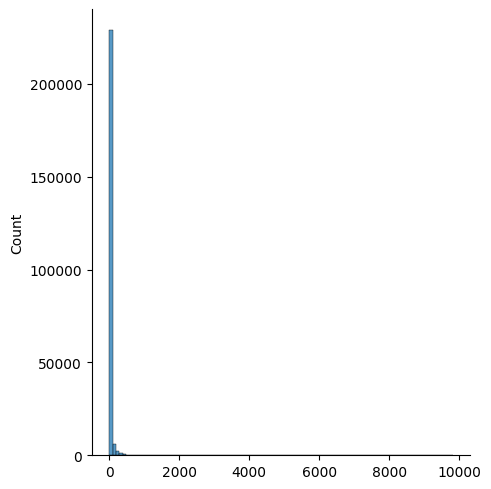

In [76]:
sns.displot(final_preds, bins=100)

In [77]:
pd.read_csv(DATA + "forecast_example.csv", sep=";").columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'forecast_weight', 'forecast_wagon_count'],
      dtype='object')

In [78]:
NEEDED_COLUMNS = ['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id', 'forecast_wagon_count']

In [79]:
forecast_example["forecast_wagon_count"] = final_preds
forecast_example = forecast_example[NEEDED_COLUMNS]
forecast_example

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_wagon_count
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,3.461860
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,3.633745
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,4.993608
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,8.094735
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,2.825316
...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,1.975611
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,0.466580
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,0.000000
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,22.119130


In [80]:
forecast_example.dtypes

period                    datetime64[ns]
rps                                int64
podrod                             int64
filial                             int64
client_sap_id                      int64
freight_id                         int64
sender_station_id                  int64
recipient_station_id               int64
sender_organisation_id             int64
forecast_wagon_count             float64
dtype: object

In [91]:
forecast_example.columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'forecast_wagon_count'],
      dtype='object')

In [92]:
forecast_example.to_csv("submission_drop_outliers_regressor_228.csv", index=False, sep=";", decimal=",", encoding="windows-1251")